# CS211: Data Privacy
## In-Class Exercise, week of 10/17/2022

In [1]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

adult = pd.read_csv('https://github.com/jnear/cs211-data-privacy/raw/master/homework/adult_with_pii.csv')

/tmp/ipykernel_11637/4252180317.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
def gaussian_mech_RDP(val, sensitivity, alpha, epsilon):
    sigma = np.sqrt((sensitivity**2 * alpha) / (2 * epsilon))
    return val + np.random.normal(loc=0, scale=sigma)

## Question 1

Use the sample-and-aggregate framework to calculate the sum of ages in the adult dataset with differential privacy.

In [1]:
def saa_avg_age(k, epsilon):
    df = adult['Age']

    chunk_size = int(np.ceil(df.shape[0] / k))

    # split the data into chunks
    chunks = [df[i:i+chunk_size] for i in range(0 , df.shape[0], chunk_size)]

    # run the query on ezch chunk
    answers = [chunk.sum() for chunk in chunks]


    # clip the answers with clipping parameter b
    upper = 2500 # this clipping parameter applies to the output of the query on each chunk
    lower = 0
    clipped_answers = np.clip(answers, lower, upper)
    sensitivity = upper  - lower

    # sum the clipped answers (sensitivity = b)
    sum_result = np.sum(clipped_answers)

    # add noise to the sum (scale = b /epsilon)
    noisy_sum = laplace_mech(sum_result, sensitivity, epsilon)
    return noisy_sum

saa_avg_age(600, 1)    

NameError: name 'adult' is not defined

## Question 2

What is the impact of the parameter `k`?

k = number of chunks.
- If k is large, many chunks, each one will fewer rows.
    - In this case, many chunks ends up with answers that are far from the query result, this is because small query groups.
- If k is small, few chunks, each one will has many rows.
    - Each chunk likely does a good job at approximating the full dataset
    - BUT aggregating over fewer chunks, needs noise

## Question 3

Calculate the empirical *cumulative distribution function* of ages in the adult dataset. Use the RDP Gaussian mechanism.

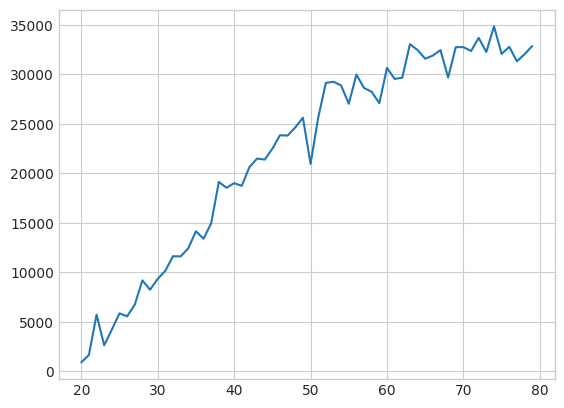

In [11]:
def gaussian_mech_RDP_vec(vec, sens, alpha, epsilon):
    return [gaussian_mech_RDP(x, sens, alpha, epsilon) for x in vec]



def calculate_cdf():
    alpha = 5
    epsilon = 0.0001
    # Different implementation for running gaussian mech on vectors
    # Total epsilon is all of calls on vec
    # true cdf gives smooth graph, noisy is spiky implying noise!
    # big epsilon = less noise; but typical values are mihc smaller than epsil
    # on values in pure or epsilon delta privacy
    L2_sens = np.sqrt(60)
    true_cdf = [len(adult[adult['Age'] < x]) for x in range(20,80)]
    noisy_cdf = gaussian_mech_RDP_vec(true_cdf, L2_sens, alpha, epsilon) 
    return noisy_cdf

cdf_vals = calculate_cdf()
plt.plot(range(20, 80), cdf_vals);

## Question 4

What is the *total privacy cost* in RDP of your solution above?

- use L2 sensitivity for the cdf vector, each query within the vector is a counting query, sensitivity 1. Thus the total L2 sensitivity is sqrt(60)
- call the gaussian mechanism 1 time for a total privacy cost of(alpha, epsilon)-RDP
- immediately return noisy results

In [12]:
def convert_rdp(alpha, epsilon_bar, delta):
    # 𝜖=𝜖¯+log(1/𝛿)𝛼−1
    epsilon = epsilon_bar + (np.log(1/delta) / (alpha -1))
    return epsilon
convert_rdp(5, .0001, 1e-5)

2.8783313662425574

## Question 5

What is the *total privacy cost* in $(\epsilon, \delta)$-differential privacy of your solution above, for $\delta = 10^{-5}$?

- the total privacy cost is (2.878, 1e-5)-differential privacy

## Question 6

Repeat question 3, but for zero-concentrated differential privacy.

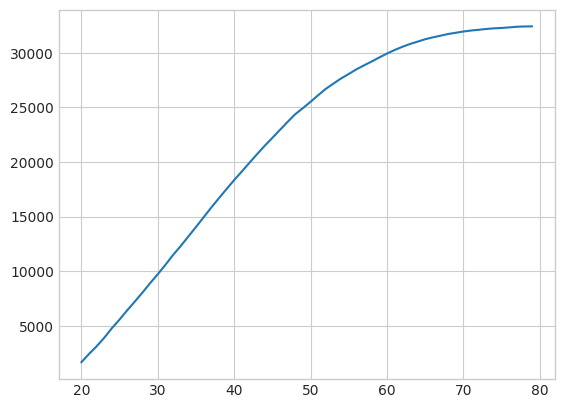

In [13]:
def gaussian_mech_zCDP(val, sensitivity, rho):
    # 𝜎2=Δ𝑓2/2𝜌 / (2*rho)
    sigma_sq = sensitivity**2
    sigma = np.sqrt(sigma_sq)
    return val + np.random.normal(loc=0, scale=sigma)

def gaussian_mech_zCDP_vec(vec, sensitivity, rho):
    return [gaussian_mech_zCDP(v, sensitivity, rho) for v in vec]

def calculate_cdf_zcdp():
    rho = 0.00001
    L2_sens = np.sqrt(60)
    true_cdf = [len(adult[adult['Age'] < x]) for x in range(20,80)]
    noisy_cdf = gaussian_mech_zCDP_vec(true_cdf, L2_sens, rho) 
    return noisy_cdf

cdf_vals = calculate_cdf_zcdp()
plt.plot(range(20, 80), cdf_vals);